# Trabajo Final - Sistemas de recomendación : Comparativo de Sistemas de recomendacion

📊 Anime Recommendation Database 2020
Este repositorio utiliza el dataset Anime Recommendation Database 2020, que contiene información de 17,562 animes y las preferencias de 325,772 usuarios.

📁 Contenido del dataset
El dataset incluye:

Lista de animes por usuario: incluye estados como completado, en curso, en pausa, abandonado y planeado.
Calificaciones dadas por los usuarios a los animes que han visto completamente.
Información general del anime: géneros, estadísticas, estudios, etc.
Archivos HTML con información scrappeada de MyAnimeList (reseñas, sinopsis, staff, estadísticas, etc.).
Código de recolección de datos disponible en este repositorio.
⚠️ Advertencia: el dataset incluye información sobre anime para adultos (hentai).

Los datos fueron recolectados entre el 26 de febrero y el 20 de marzo de 2020.

OBJETIVO: construir un modelo de recomendacion que permita brindar las mejores recomendaciones de anime a los consumidores de este genero.

Links de data:


-anime : https://drive.google.com/file/d/1367Bjj-GQ5lasreqY9jsbw2TWrhzRAx5/view?usp=drive_link

-rating : https://drive.google.com/file/d/1ZdwasdEdgTdS9bxPPxXpcor84bmBRkRs/view?usp=drive_link








## Dependencias

In [1]:
!pip install tensorflow==2.17.1

In [2]:
!pip install gdown py7zr

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import gzip
import json
import re
import urllib.request
import os
from collections import defaultdict, Counter
from textblob import TextBlob
import nltk

In [4]:
from sklearn.preprocessing import LabelEncoder
import gdown
import py7zr

In [5]:
# Configurar NLTK
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

warnings.filterwarnings('ignore')

# Configuración visual
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## Carga y exploración de los datos

In [6]:
def load_gdrive_csv_to_df(gdrive_id: str, sample_size: int = None, random_seed: int = 42, **kwargs) -> pd.DataFrame:
    """
    Descarga un archivo .csv desde Google Drive y lo carga en un DataFrame.
    Opcionalmente, puede cargar una muestra aleatoria del dataset.

    Args:
        gdrive_id (str): El ID del archivo de Google Drive.
        sample_size (int, optional): El número de filas para la muestra aleatoria.
                                     Si es None, se carga el dataset completo. Defaults to None.
        random_seed (int, optional): Semilla para la generación de la muestra aleatoria,
                                     lo que garantiza la reproducibilidad. Defaults to 42.
        **kwargs: Argumentos adicionales para pasar a pd.read_csv (ej. parse_dates).

    Returns:
        pd.DataFrame: El DataFrame con los datos cargados.
    """

    url = f'https://drive.google.com/uc?id={gdrive_id}'
    output_filename = f'temp_{gdrive_id}.csv'

    try:
        # --- 1. Descargar 📥 ---
        print("Descargando archivo desde Google Drive...")
        gdown.download(url, output_filename, quiet=True)

        # --- 2. Cargar a DataFrame 📊 ---
        print(f"Cargando '{output_filename}' en DataFrame...")
        df = pd.read_csv(output_filename, **kwargs)

        # --- 3. Lógica de Muestreo Aleatorio (NUEVO) 🎲 ---
        if sample_size is not None:
            # Comprueba si el tamaño de la muestra es válido
            if sample_size > len(df):
                print(f"⚠️  Advertencia: El tamaño de muestra ({sample_size}) es mayor que el dataset ({len(df)}). Se devolverá el dataset completo.")
            else:
                print(f"Tomando una muestra aleatoria de {sample_size} filas...")
                df = df.sample(n=sample_size, random_state=random_seed)

        print("✅ ¡Proceso completado con éxito!")
        return df

    except Exception as e:
        print(f"❌ Ocurrió un error: {e}")
        return None

    finally:
        # --- 4. Limpieza 🧹 ---
        if os.path.exists(output_filename):
            os.remove(output_filename)

In [7]:
id_anime              ='1367Bjj-GQ5lasreqY9jsbw2TWrhzRAx5'
id_rating_complete    ='1ZdwasdEdgTdS9bxPPxXpcor84bmBRkRs'

In [8]:
anime_df              =load_gdrive_csv_to_df(id_anime)
rating_df             =load_gdrive_csv_to_df(id_rating_complete, sample_size=800000)


Descargando archivo desde Google Drive...
Cargando 'temp_1367Bjj-GQ5lasreqY9jsbw2TWrhzRAx5.csv' en DataFrame...
✅ ¡Proceso completado con éxito!
Descargando archivo desde Google Drive...
Cargando 'temp_1ZdwasdEdgTdS9bxPPxXpcor84bmBRkRs.csv' en DataFrame...
Tomando una muestra aleatoria de 800000 filas...
✅ ¡Proceso completado con éxito!


In [9]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800000 entries, 7806172 to 2684823
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   user_id   800000 non-null  int64
 1   anime_id  800000 non-null  int64
 2   rating    800000 non-null  int64
dtypes: int64(3)
memory usage: 24.4 MB


In [10]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [11]:
def summarize_df(df, name="DataFrame"):
    """
    Imprime un resumen detallado de un DataFrame de Pandas.
    """
    print(f"---  RESUMEN DEL DATAFRAME: {name} ---\n")

    # 1. Dimensiones (filas, columnas)
    print(f"📈 Dimensiones: {df.shape[0]} filas y {df.shape[1]} columnas\n")

    # 2. Tipos de datos y valores no nulos
    print("📋 Información General y Tipos de Datos:")
    df.info()
    print("\n" + "-"*50 + "\n")

    # 3. Muestra de los datos
    print("👀 Primeras 5 filas:")
    display(df.head())
    print("\n" + "-"*50 + "\n")

    # 4. Estadísticas descriptivas para columnas numéricas
    print("📊 Estadísticas Descriptivas (Columnas Numéricas):")
    display(df.describe())
    print("\n" + "-"*50 + "\n")

    # 5. Estadísticas descriptivas para columnas de texto/categóricas
    # El método describe con include='object' es útil para columnas de texto.
    if not df.select_dtypes(include='object').empty:
      print("📝 Estadísticas Descriptivas (Columnas de Texto):")
      display(df.describe(include='object'))
      print("\n" + "-"*50 + "\n")

    # 6. Conteo de valores nulos
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print("❓ Porcentaje de Valores Nulos por Columna:")
        print((missing_values[missing_values > 0] / df.shape[0] * 100).sort_values(ascending=False))
    else:
        print("✅ No se encontraron valores nulos.")

    print("\n" + "="*50 + "\n")

In [12]:
summarize_df(anime_df, name="df_anime")

---  RESUMEN DEL DATAFRAME: df_anime ---

📈 Dimensiones: 12294 filas y 7 columnas

📋 Información General y Tipos de Datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB

--------------------------------------------------

👀 Primeras 5 filas:


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266



--------------------------------------------------

📊 Estadísticas Descriptivas (Columnas Numéricas):


,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06



--------------------------------------------------

📝 Estadísticas Descriptivas (Columnas de Texto):


,name,genre,type,episodes
count,12294,12232,12269,12294
unique,12292,3264,6,187
top,Shi Wan Ge Leng Xiaohua,Hentai,TV,1
freq,2,823,3787,5677



--------------------------------------------------

❓ Porcentaje de Valores Nulos por Columna:
rating    1.870831
genre     0.504311
type      0.203351
dtype: float64




In [13]:
summarize_df(rating_df, name="df_anime")

---  RESUMEN DEL DATAFRAME: df_anime ---

📈 Dimensiones: 800000 filas y 3 columnas

📋 Información General y Tipos de Datos:
<class 'pandas.core.frame.DataFrame'>
Index: 800000 entries, 7806172 to 2684823
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   user_id   800000 non-null  int64
 1   anime_id  800000 non-null  int64
 2   rating    800000 non-null  int64
dtypes: int64(3)
memory usage: 24.4 MB

--------------------------------------------------

👀 Primeras 5 filas:


,user_id,anime_id,rating
7806172,73424,7785,10
6470262,59789,19769,6
5975474,55960,59,10
7617688,71461,3342,10
5932334,55390,986,8



--------------------------------------------------

📊 Estadísticas Descriptivas (Columnas Numéricas):


,user_id,anime_id,rating
count,800000.000000,800000.000000,800000.000000
mean,36724.952200,8907.820242,6.143865
std,21008.242019,8891.988352,3.730802
min,1.000000,1.000000,-1.000000
25%,18912.000000,1241.000000,6.000000
50%,36826.000000,6211.000000,7.000000
75%,54774.000000,14075.000000,9.000000
max,73515.000000,34325.000000,10.000000



--------------------------------------------------

✅ No se encontraron valores nulos.




## Preparación y limpieza de datos

In [14]:
# clean anime
anime_df = anime_df.dropna(subset=['genre', 'type']).reset_index(drop=True)

anime_df = anime_df.fillna(value= 0).reset_index(drop=True)

anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12210 entries, 0 to 12209
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12210 non-null  int64  
 1   name      12210 non-null  object 
 2   genre     12210 non-null  object 
 3   type      12210 non-null  object 
 4   episodes  12210 non-null  object 
 5   rating    12210 non-null  float64
 6   members   12210 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 667.9+ KB


In [15]:
# Drop duplicates
anime_df = anime_df.drop_duplicates(subset=['name']).reset_index(drop = True)
rating_df = rating_df.drop_duplicates().reset_index(drop=True)

anime_df.shape, rating_df.shape

((12208, 7), (800000, 3))

In [16]:
# column episodes is number but was load as string
anime_df.loc[anime_df['episodes'] == 'Unknown', 'episodes'] = 0     # ---> 'Unknown' VALUE BECOME 0 IN EPISODES COLUMN
anime_df['episodes'] = anime_df['episodes'].astype('int32')
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12208 entries, 0 to 12207
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12208 non-null  int64  
 1   name      12208 non-null  object 
 2   genre     12208 non-null  object 
 3   type      12208 non-null  object 
 4   episodes  12208 non-null  int32  
 5   rating    12208 non-null  float64
 6   members   12208 non-null  int64  
dtypes: float64(1), int32(1), int64(2), object(3)
memory usage: 620.1+ KB


In [17]:
# rating -1 significa que el cliente no dado un puntaje, por lo que eliminamos los datos
rating_df = rating_df[rating_df['rating'] != -1]

In [18]:
rating_df

,user_id,anime_id,rating
0,73424,7785,10
1,59789,19769,6
2,55960,59,10
3,71461,3342,10
4,55390,986,8
...,...,...,...
799992,59528,853,9
799993,52183,2490,7
799994,73212,190,8
799996,52759,550,5


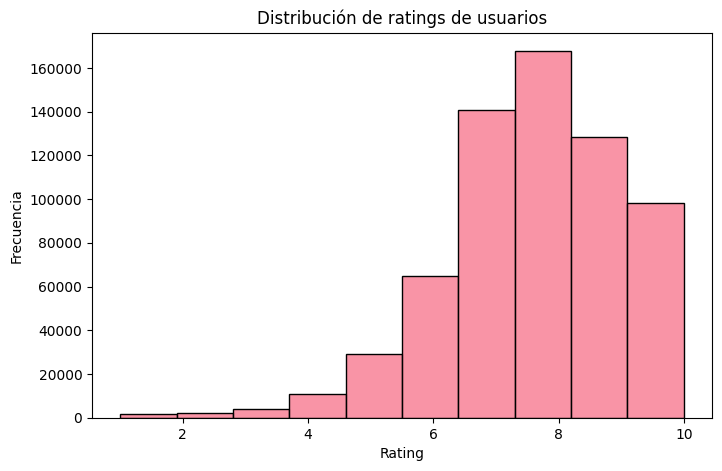

In [19]:
plt.figure(figsize=(8,5))
sns.histplot(rating_df["rating"], bins=10, kde=False)
plt.title("Distribución de ratings de usuarios")
plt.xlabel("Rating")
plt.ylabel("Frecuencia")
plt.show()

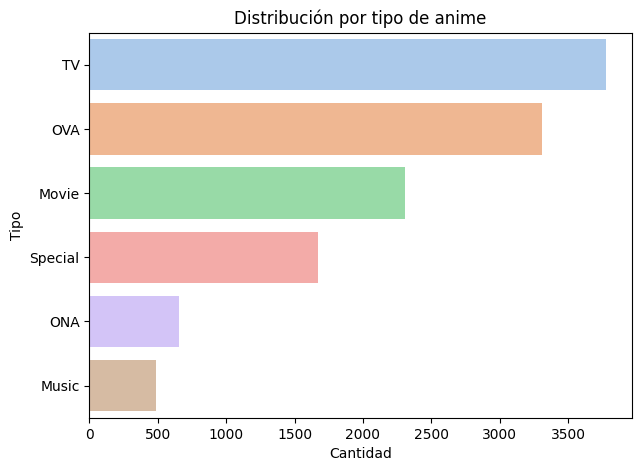

In [20]:
plt.figure(figsize=(7,5))
sns.countplot(y="type", data=anime_df, order=anime_df["type"].value_counts().index, palette="pastel")
plt.title("Distribución por tipo de anime")
plt.xlabel("Cantidad")
plt.ylabel("Tipo")
plt.show()

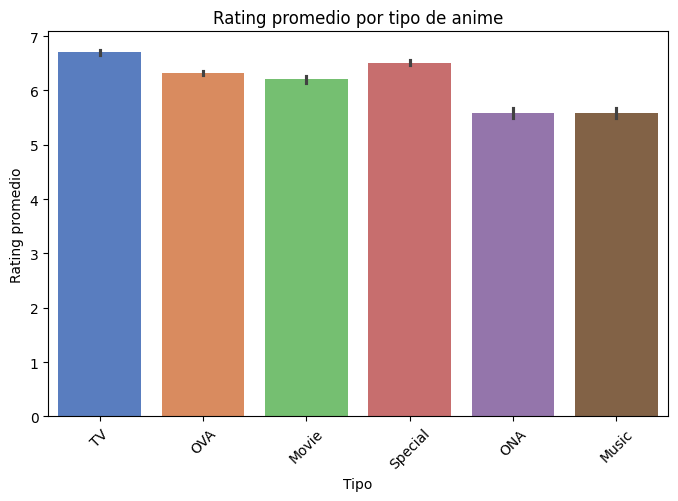

In [21]:
plt.figure(figsize=(8,5))
sns.barplot(x="type", y="rating", data=anime_df, palette="muted", order=anime_df["type"].value_counts().index)
plt.title("Rating promedio por tipo de anime")
plt.xlabel("Tipo")
plt.ylabel("Rating promedio")
plt.xticks(rotation=45)
plt.show()

In [22]:
anime_df

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12203,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12204,5543,Under World,Hentai,OVA,1,4.28,183
12205,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12206,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [23]:
# Limpieza de datos de metadata
metadata_clean = anime_df[['anime_id', 'name', 'genre', 'type','episodes']].copy()
metadata_clean.columns = ['item_id', 'title', 'categories', 'type','episodes']
metadata_clean = metadata_clean.dropna()

print(f" Metadata original: {len(metadata_clean)}")

 Metadata original: 12208


In [24]:
# Limpieza de datos de metadata
reviews_clean = rating_df[['user_id', 'anime_id', 'rating']].copy()
reviews_clean.columns = ['user_id', 'item_id', 'rating']
reviews_clean = reviews_clean.dropna()

print(f" Metadata original: {len(reviews_clean)}")

 Metadata original: 648643


In [25]:
# Análisis de intersección
print(f"reviews unicos: {reviews_clean["item_id"].nunique():,}")
print(f"metadata unicos: {metadata_clean["item_id"].nunique():,}")

reviews unicos: 7,840
metadata unicos: 12,208


In [26]:
# Verificar intersección
common_items = set(reviews_clean['item_id']) & set(metadata_clean['item_id'])
print(f"IDs comunes: {len(common_items):,}")

if len(common_items) == 0:
    print(" NO HAY INTERSECCIÓN - Creando dataset sintético para el tutorial...")
else:
    # Usar datos reales si hay intersección
    reviews_final = reviews_clean[reviews_clean['item_id'].isin(common_items)]
    metadata_final = metadata_clean[metadata_clean['item_id'].isin(common_items)]
    print(f" Usando datos reales:")

print(f"    Reviews finales: {len(reviews_final):,}")
print(f"    Productos finales: {len(metadata_final):,}")
print(f"    Usuarios únicos: {reviews_final['user_id'].nunique():,}")

IDs comunes: 7,831
 Usando datos reales:
    Reviews finales: 648,629
    Productos finales: 7,831
    Usuarios únicos: 57,453


## Análisis exploratorio

In [27]:
if len(reviews_final) > 0:
    print(" ESTADÍSTICAS GENERALES:")
    print(f"    Rating promedio: {reviews_final['rating'].mean():.2f}")
    print(f"    Mediana de rating: {reviews_final['rating'].median():.1f}")

    # Verificar que hay datos para mode
    mode_values = reviews_final['rating'].mode()
    if len(mode_values) > 0:
        print(f"    Rating más común: {mode_values.iloc[0]}")
    else:
        print(f"    Rating más común: N/A")

    # Análisis de actividad
    user_activity = reviews_final.groupby('user_id').size()
    item_popularity = reviews_final.groupby('item_id').size()

    print(f"\n ANÁLISIS DE USUARIOS:")
    print(f"    Promedio reviews por usuario: {user_activity.mean():.1f}")
    print(f"    Máximo reviews por usuario: {user_activity.max()}")
    print(f"    Mínimo reviews por usuario: {user_activity.min()}")

    print(f"\n ANÁLISIS DE PRODUCTOS:")
    print(f"    Promedio reviews por producto: {item_popularity.mean():.1f}")
    print(f"    Producto más popular: {item_popularity.max()} reviews")
else:
    print(" No hay datos de reviews para analizar")
    # Crear datos mínimos para que el resto del código funcione
    user_activity = pd.Series([1], index=['U0001'])
    item_popularity = pd.Series([1], index=['B000001X'])

 ESTADÍSTICAS GENERALES:
    Rating promedio: 7.81
    Mediana de rating: 8.0
    Rating más común: 8

 ANÁLISIS DE USUARIOS:
    Promedio reviews por usuario: 11.3
    Máximo reviews por usuario: 373
    Mínimo reviews por usuario: 1

 ANÁLISIS DE PRODUCTOS:
    Promedio reviews por producto: 82.8
    Producto más popular: 3518 reviews


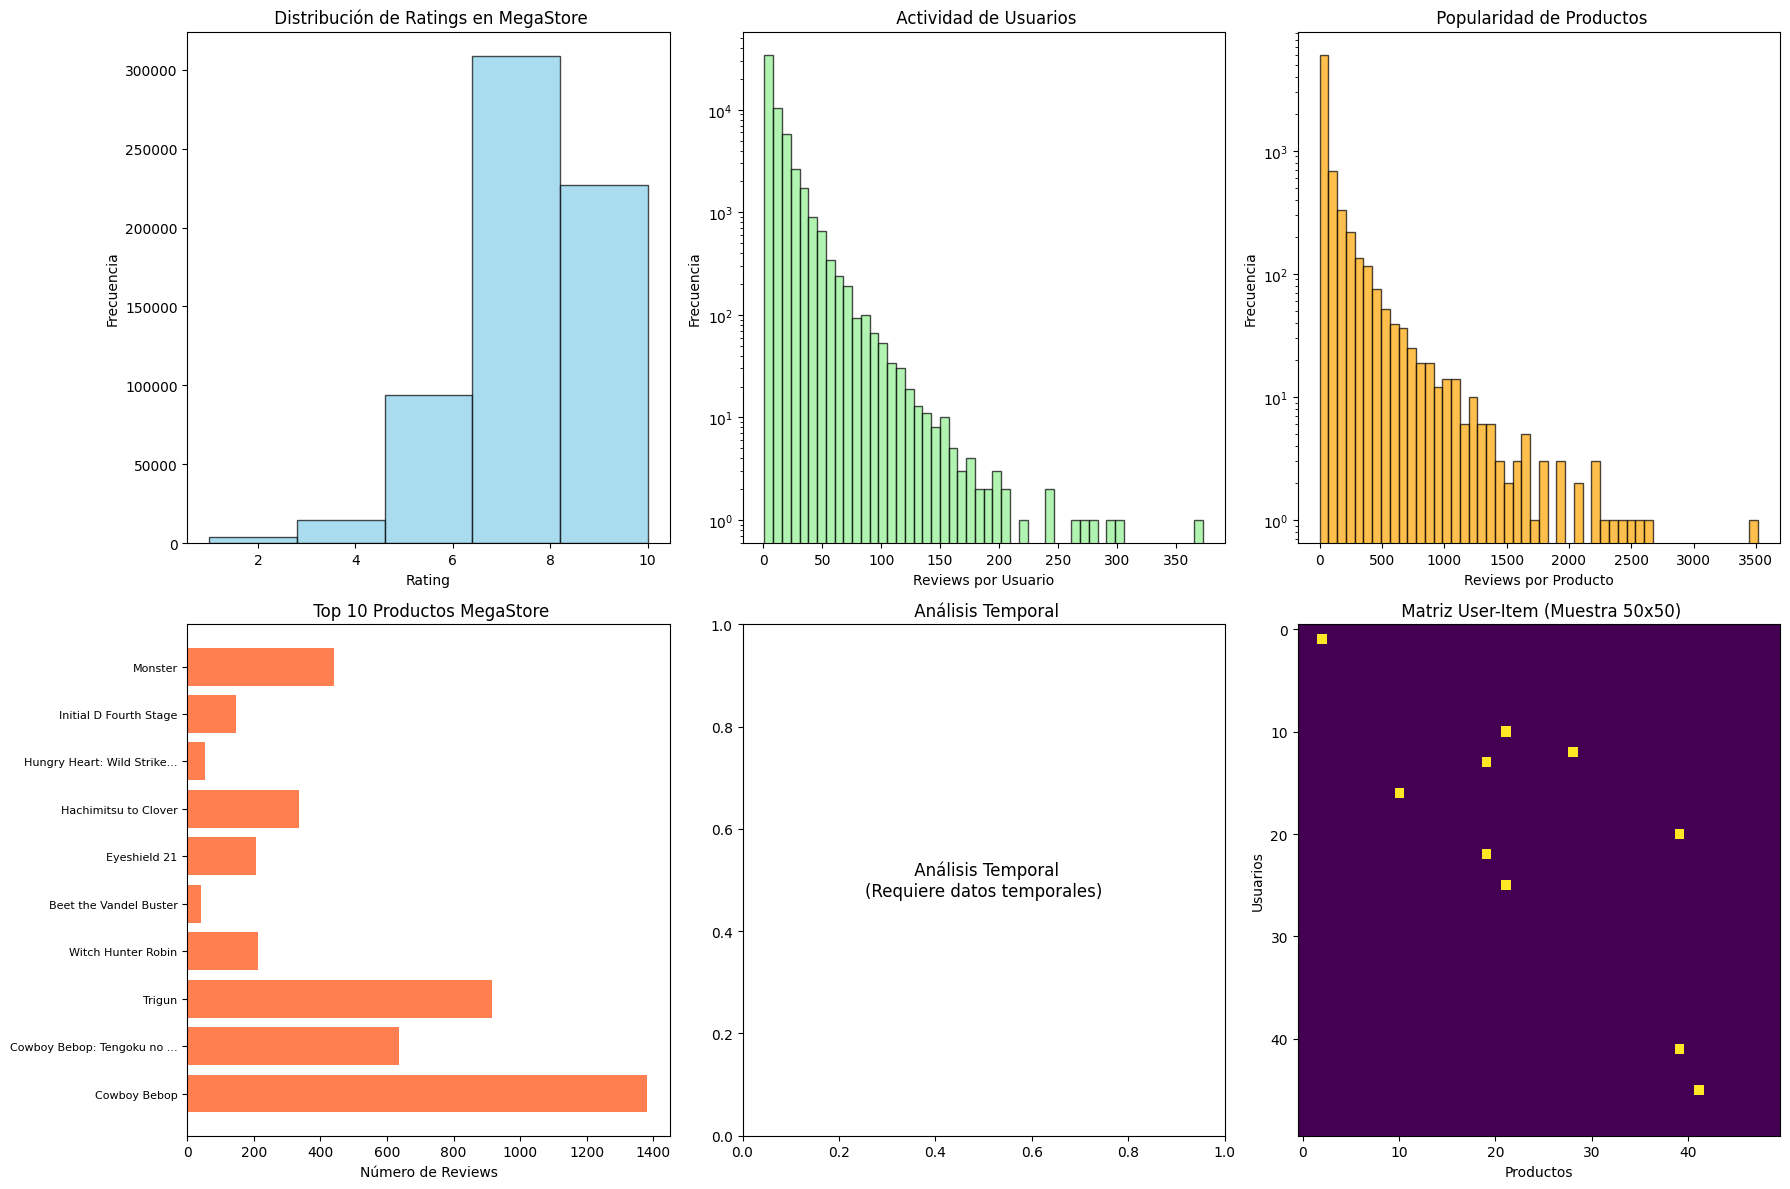

In [28]:
# Visualizaciones
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Distribución de ratings
axes[0,0].hist(reviews_final['rating'], bins=5, edgecolor='black', alpha=0.7, color='skyblue')
axes[0,0].set_title(' Distribución de Ratings en MegaStore')
axes[0,0].set_xlabel('Rating')
axes[0,0].set_ylabel('Frecuencia')

# Actividad de usuarios
axes[0,1].hist(user_activity, bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0,1].set_title(' Actividad de Usuarios')
axes[0,1].set_xlabel('Reviews por Usuario')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].set_yscale('log')

# Popularidad de productos
axes[0,2].hist(item_popularity, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0,2].set_title(' Popularidad de Productos')
axes[0,2].set_xlabel('Reviews por Producto')
axes[0,2].set_ylabel('Frecuencia')
axes[0,2].set_yscale('log')

# Top 10 productos más populares
top_items = item_popularity.head(10)
product_names = []
for item_id in top_items.index:
    title = metadata_final[metadata_final['item_id'] == item_id]['title']
    if not title.empty:
        name = title.iloc[0][:25] + '...' if len(title.iloc[0]) > 25 else title.iloc[0]
    else:
        name = f"Producto {item_id[:8]}"
    product_names.append(name)

axes[1,0].barh(range(len(product_names)), top_items.values, color='coral')
axes[1,0].set_yticks(range(len(product_names)))
axes[1,0].set_yticklabels(product_names, fontsize=8)
axes[1,0].set_title(' Top 10 Productos MegaStore')
axes[1,0].set_xlabel('Número de Reviews')

# Distribución temporal (si hay timestamp)
axes[1,1].text(0.5, 0.5, ' Análisis Temporal\n(Requiere datos temporales)',
               ha='center', va='center', transform=axes[1,1].transAxes, fontsize=12)
axes[1,1].set_title(' Análisis Temporal')

# Matriz de sparsity (muestra)
sample_matrix = reviews_final.pivot_table(
    index='user_id', columns='item_id', values='rating', fill_value=0
).iloc[:50, :50]
axes[1,2].imshow(sample_matrix > 0, cmap='viridis', aspect='auto')
axes[1,2].set_title(' Matriz User-Item (Muestra 50x50)')
axes[1,2].set_xlabel('Productos')
axes[1,2].set_ylabel('Usuarios')

plt.tight_layout()
plt.show()

In [29]:
reviews_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 648629 entries, 0 to 799997
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  648629 non-null  int64
 1   item_id  648629 non-null  int64
 2   rating   648629 non-null  int64
dtypes: int64(3)
memory usage: 19.8 MB


In [30]:
# Calcular sparsity (con validación)
total_users = reviews_final['user_id'].nunique()
total_items = reviews_final['item_id'].nunique()
total_ratings = len(reviews_final)
possible_ratings = total_users * total_items

sparsity = 1 - (total_ratings / possible_ratings)
print(f" Sparsity: {sparsity:.2%}")

 Sparsity: 99.86%


In [31]:
# Forma final de reviewers
reviews_final.info()
reviews_final.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
Index: 648629 entries, 0 to 799997
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  648629 non-null  int64
 1   item_id  648629 non-null  int64
 2   rating   648629 non-null  int64
dtypes: int64(3)
memory usage: 19.8 MB


,user_id,item_id,rating
count,648629.000000,648629.000000,648629.000000
mean,36745.686147,8898.293323,7.810889
std,21026.549920,8891.334633,1.574501
min,3.000000,1.000000,1.000000
25%,18940.000000,1238.000000,7.000000
50%,36856.000000,6205.000000,8.000000
75%,54883.000000,14075.000000,9.000000
max,73515.000000,34325.000000,10.000000


In [32]:
# Forma final de metadata
metadata_final.info()
metadata_final.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
Index: 7831 entries, 0 to 12204
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_id     7831 non-null   int64 
 1   title       7831 non-null   object
 2   categories  7831 non-null   object
 3   type        7831 non-null   object
 4   episodes    7831 non-null   int32 
dtypes: int32(1), int64(1), object(3)
memory usage: 336.5+ KB


,item_id,title,categories,type,episodes
count,7831.000000,7831,7831,7831,7831.000000
unique,NaN,7831,2803,6,NaN
top,NaN,Kimi no Na wa.,Hentai,TV,NaN
freq,NaN,1,673,2656,NaN
mean,9842.636956,NaN,NaN,NaN,12.150172
std,9764.984092,NaN,NaN,NaN,42.136562
min,1.000000,NaN,NaN,NaN,1.000000
25%,2193.500000,NaN,NaN,NaN,1.000000
50%,5895.000000,NaN,NaN,NaN,2.000000
75%,15130.000000,NaN,NaN,NaN,12.000000


## ITEM-BASED COLLABORATIVE FILTERING

## Clase que implementa el modelo

In [33]:
class ItemBasedCollaborativeFiltering:
    def __init__(self, ratings_df, min_interactions=5):
        """
        Item-based collaborative filtering implementation

        Parameters:
        - ratings_df: DataFrame with columns ['user_id', 'item_id', 'rating']
        - min_interactions: Minimum interactions required for items to be considered
        """
        self.ratings_df = ratings_df
        self.min_interactions = min_interactions
        self.item_similarity_matrix = None
        self.user_item_matrix = None
        self.item_means = None

    def build_model(self):
        """Build the item-item similarity matrix"""
        print("Building item-based collaborative filtering model...")

        # Filter items with minimum interactions
        item_counts = self.ratings_df['item_id'].value_counts()
        valid_items = item_counts[item_counts >= self.min_interactions].index
        filtered_df = self.ratings_df[self.ratings_df['item_id'].isin(valid_items)]

        print(f"Items after filtering (min {self.min_interactions} interactions): {len(valid_items)}")

        # Create user-item matrix
        self.user_item_matrix = filtered_df.pivot_table(
            index='user_id',
            columns='item_id',
            values='rating',
            fill_value=0
        )

        # Calculate item means (for mean-centered similarity)
        self.item_means = self.user_item_matrix.mean(axis=0)

        # Mean-center the matrix
        user_item_centered = self.user_item_matrix.subtract(self.item_means, axis=1)

        # Calculate item-item cosine similarity
        print("Calculating item-item similarities...")
        self.item_similarity_matrix = cosine_similarity(user_item_centered.T)

        # Convert to DataFrame for easier handling
        items = self.user_item_matrix.columns
        self.item_similarity_df = pd.DataFrame(
            self.item_similarity_matrix,
            index=items,
            columns=items
        )

        print("Item-based model built successfully!")

    def get_item_similarities(self, item_id, top_k=10):
        """Get most similar items to a given item"""
        if self.item_similarity_df is None:
            raise ValueError("Model not built yet. Call build_model() first.")

        if item_id not in self.item_similarity_df.index:
            return f"Item {item_id} not found in similarity matrix"

        similarities = self.item_similarity_df[item_id].drop(item_id).sort_values(ascending=False)
        return similarities.head(top_k)

    def predict_rating(self, user_id, item_id, k=20):
        """Predict rating for a user-item pair using k most similar items"""
        if self.item_similarity_df is None:
            raise ValueError("Model not built yet. Call build_model() first.")

        # Check if user and item exist in our matrices
        if user_id not in self.user_item_matrix.index:
            return self.item_means.get(item_id, self.ratings_df['rating'].mean())

        if item_id not in self.item_similarity_df.columns:
            return self.ratings_df['rating'].mean()

        # Get user's ratings
        user_ratings = self.user_item_matrix.loc[user_id]

        # Get items that user has rated
        rated_items = user_ratings[user_ratings > 0].index

        if len(rated_items) == 0:
            return self.item_means.get(item_id, self.ratings_df['rating'].mean())

        # Get similarities between target item and user's rated items
        item_similarities = self.item_similarity_df.loc[item_id, rated_items]

        # Sort by similarity and take top k
        item_similarities = item_similarities.sort_values(ascending=False).head(k)

        # Calculate weighted prediction
        numerator = 0
        denominator = 0

        for similar_item, similarity in item_similarities.items():
            if similarity > 0:  # Only consider positive similarities
                user_rating = user_ratings[similar_item]
                item_mean = self.item_means[similar_item]
                numerator += similarity * (user_rating - item_mean)
                denominator += abs(similarity)

        if denominator == 0:
            return self.item_means.get(item_id, self.ratings_df['rating'].mean())

        predicted_rating = self.item_means[item_id] + (numerator / denominator)

        # Clip to valid rating range
        predicted_rating = max(1, min(5, predicted_rating))

        return predicted_rating

    def recommend_items(self, user_id, n_recommendations=10, exclude_rated=True):
        """Generate item recommendations for a user"""
        if self.item_similarity_df is None:
            raise ValueError("Model not built yet. Call build_model() first.")

        if user_id not in self.user_item_matrix.index:
            # For new users, recommend popular items
            popular_items = self.ratings_df.groupby('item_id').agg({
                'rating': ['count', 'mean']
            }).round(2)
            popular_items.columns = ['count', 'mean_rating']
            popular_items = popular_items.sort_values(['count', 'mean_rating'], ascending=False)
            return popular_items.head(n_recommendations)

        # Get items user has already rated
        user_ratings = self.user_item_matrix.loc[user_id]
        rated_items = set(user_ratings[user_ratings > 0].index) if exclude_rated else set()

        # Get all items in similarity matrix
        all_items = set(self.item_similarity_df.columns)
        candidate_items = all_items - rated_items if exclude_rated else all_items

        # Predict ratings for candidate items
        recommendations = []
        for item_id in candidate_items:
            predicted_rating = self.predict_rating(user_id, item_id)
            recommendations.append({
                'item_id': item_id,
                'predicted_rating': predicted_rating
            })

        # Sort by predicted rating
        recommendations = sorted(recommendations, key=lambda x: x['predicted_rating'], reverse=True)

        return recommendations[:n_recommendations]

## Construir el modelo

In [34]:
# Initialize and build the item-based model
print("ITEM-BASED COLLABORATIVE FILTERING")
print("="*40)

item_cf = ItemBasedCollaborativeFiltering(reviews_final, min_interactions=10)
item_cf.build_model()

ITEM-BASED COLLABORATIVE FILTERING
Building item-based collaborative filtering model...
Items after filtering (min 10 interactions): 4245
Calculating item-item similarities...
Item-based model built successfully!


## Estadísticas

In [35]:
# Estadisticas del modelo
print(item_cf.user_item_matrix.shape)
print(item_cf.item_similarity_matrix.shape)

(57415, 4245)
(4245, 4245)


## Ejemplo de similitud de items

In [37]:
# Example: Find similar items with detailed information
sample_item = item_cf.user_item_matrix.columns[0]
sample_item_info = metadata_final[metadata_final['item_id'] == sample_item].iloc[0]
similar_items = item_cf.get_item_similarities(sample_item, 5)

print(f"\nSIMILAR ITEMS ANALYSIS:")
print("="*50)
print(f"BASE ITEM: {sample_item}")
print(f"Title: {sample_item_info['title']}")
print(f"Categories: {sample_item_info['categories']}")

print(f"\nMOST SIMILAR ITEMS:")
print("-"*30)
for item_id, similarity in similar_items.items():
    try:
        item_info = metadata_final[metadata_final['item_id'] == item_id].iloc[0]
        print(f"\nSimilarity: {similarity:.3f}")
        print(f"  Item ID: {item_id}")
        print(f"  Title: {item_info['title']}")
        print(f"  Categories: {item_info['categories']}")
    except:
        print(f"  {item_id}: {similarity:.3f} (metadata not found)")


SIMILAR ITEMS ANALYSIS:
BASE ITEM: 1
Title: Cowboy Bebop
Categories: Action, Adventure, Comedy, Drama, Sci-Fi, Space

MOST SIMILAR ITEMS:
------------------------------

Similarity: 0.047
  Item ID: 5
  Title: Cowboy Bebop: Tengoku no Tobira
  Categories: Action, Drama, Mystery, Sci-Fi, Space

Similarity: 0.042
  Item ID: 47
  Title: Akira
  Categories: Action, Adventure, Horror, Military, Sci-Fi, Supernatural

Similarity: 0.040
  Item ID: 205
  Title: Samurai Champloo
  Categories: Action, Adventure, Comedy, Historical, Samurai, Shounen

Similarity: 0.039
  Item ID: 6
  Title: Trigun
  Categories: Action, Comedy, Sci-Fi

Similarity: 0.038
  Item ID: 33
  Title: Berserk
  Categories: Action, Adventure, Demons, Drama, Fantasy, Horror, Military, Romance, Seinen, Supernatural


## Ejecución de recomendación para usuarios

In [38]:
# Ejemplo de recomendacion
sample_user = item_cf.user_item_matrix.index[10]
user_history = reviews_final[reviews_final['user_id'] == sample_user].sort_values('rating', ascending=False)
recommendations = item_cf.recommend_items(sample_user, 5)

print(f"\n\nUSER PROFILE ANALYSIS:")
print("="*50)
print(f"USER ID: {sample_user}")
print(f"Total ratings: {len(user_history)}")
print(f"Average rating: {user_history['rating'].mean():.2f}")
print(f"Rating distribution: {dict(user_history['rating'].value_counts().sort_index())}")

print(f"\nUSER'S TOP RATED ITEMS:")
print("-"*30)
for i, (_, rating_row) in enumerate(user_history.head(5).iterrows(), 1):
    try:
        item_info = metadata_final[metadata_final['item_id'] == rating_row['item_id']].iloc[0]
        print(f"{i}. Rating: {rating_row['rating']}/5")
        print(f"   Title: {item_info['title']}")
        print(f"   Categories: {item_info['categories']}")
    except:
        print(f"{i}. Item {rating_row['item_id']}: {rating_row['rating']}/5 (metadata not found)")

print(f"\nITEM-BASED CF RECOMMENDATIONS FOR USER {sample_user}:")
print("="*60)
for i, rec in enumerate(recommendations, 1):
    try:
        item_info = metadata_final[metadata_final['item_id'] == rec['item_id']].iloc[0]
        avg_rating = reviews_final[reviews_final['item_id'] == rec['item_id']]['rating'].mean()
        total_reviews = len(reviews_final[reviews_final['item_id'] == rec['item_id']])

        print(f"\n{i}. PREDICTED RATING: {rec['predicted_rating']:.2f}/5")
        print(f"   Item ID: {rec['item_id']}")
        print(f"   Title: {item_info['title']}")
        print(f"   Categories: {item_info['categories']}")
        print(f"   Description: {str(item_info['description'])[:150]}...")
        print(f"   Actual avg rating: {avg_rating:.2f}/5 ({total_reviews} reviews)")
    except:
        print(f"\n{i}. Item: {rec['item_id']} - Predicted Rating: {rec['predicted_rating']:.2f} (metadata not found)")





USER PROFILE ANALYSIS:
USER ID: 21
Total ratings: 16
Average rating: 7.94
Rating distribution: {4: 1, 7: 5, 8: 4, 9: 4, 10: 2}

USER'S TOP RATED ITEMS:
------------------------------
1. Rating: 10/5
   Title: Mahou Shoujo Madoka★Magica
   Categories: Drama, Magic, Psychological, Thriller
2. Rating: 10/5
   Title: Neon Genesis Evangelion: The End of Evangelion
   Categories: Dementia, Drama, Mecha, Psychological, Sci-Fi
3. Rating: 9/5
   Title: Code Geass: Hangyaku no Lelouch R2
   Categories: Action, Drama, Mecha, Military, Sci-Fi, Super Power
4. Rating: 9/5
   Title: Hellsing
   Categories: Action, Horror, Seinen, Supernatural, Vampire
5. Rating: 9/5
   Title: Non Non Biyori
   Categories: Comedy, School, Seinen, Slice of Life

ITEM-BASED CF RECOMMENDATIONS FOR USER 21:

1. PREDICTED RATING: 5.00/5
   Item ID: 1
   Title: Cowboy Bebop
   Categories: Action, Adventure, Comedy, Drama, Sci-Fi, Space

1. Item: 1 - Predicted Rating: 5.00 (metadata not found)

2. PREDICTED RATING: 5.00/5


# Content-Based Filtering

## Clase que implementa el modelo

In [41]:
class ContentBasedFiltering:
    def __init__(self, metadata_df, ratings_df):
        """
        Content-based filtering using TF-IDF on item features

        Parameters:
        - metadata_df: DataFrame with item metadata
        - ratings_df: DataFrame with ratings for building user profiles
        """
        self.metadata_df = metadata_df.copy()
        self.ratings_df = ratings_df
        self.tfidf_vectorizer = None
        self.content_matrix = None
        self.item_similarity_matrix = None

    def preprocess_content(self):
        """Preprocess and combine content features"""
        print("Preprocessing content features...")

        def convert_to_string(value):
            """Convert value to string, handling lists, arrays and None values"""
            # Handle numpy arrays and pandas arrays first
            if hasattr(value, '__array__') or isinstance(value, (list, tuple)):
                try:
                    # Convert to list if it's an array
                    if hasattr(value, 'tolist'):
                        value_list = value.tolist()
                    else:
                        value_list = list(value)
                    return ', '.join([str(item) for item in value_list if item is not None])
                except:
                    return str(value)

            # Handle scalar values
            try:
                if pd.isna(value) or value is None:
                    return ''
                else:
                    return str(value)
            except (ValueError, TypeError):
                # If pd.isna() fails, just convert to string
                return str(value) if value is not None else ''

        # Convert all columns to strings, handling lists
        self.metadata_df['title'] = self.metadata_df['title'].apply(convert_to_string)
        self.metadata_df['categories'] = self.metadata_df['categories'].apply(convert_to_string)

        # Combine all text features
        # Give different weights to different features
        self.metadata_df['combined_features'] = (
            self.metadata_df['title'] * 3 + ' ' +  # Title is most important
            self.metadata_df['categories'] * 2  # Categories are moderately important
        )

        # Clean the text
        self.metadata_df['combined_features'] = (
            self.metadata_df['combined_features']
            .str.lower()
            .str.replace(r'[^\w\s]', ' ', regex=True)
            .str.replace(r'\s+', ' ', regex=True)
            .str.strip()
        )

        print(f"Combined features created for {len(self.metadata_df)} items")

    def build_model(self, max_features=5000, min_df=2, max_df=0.8):
        """Build TF-IDF matrix and calculate item similarities"""
        if 'combined_features' not in self.metadata_df.columns:
            self.preprocess_content()

        print("Building TF-IDF matrix...")

        # Initialize TF-IDF vectorizer
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=max_features,
            min_df=min_df,
            max_df=max_df,
            stop_words='english',
            ngram_range=(1, 2)  # Include bigrams
        )

        # Fit and transform the combined features
        self.content_matrix = self.tfidf_vectorizer.fit_transform(
            self.metadata_df['combined_features']
        )

        print(f"TF-IDF matrix shape: {self.content_matrix.shape}")
        print(f"Vocabulary size: {len(self.tfidf_vectorizer.vocabulary_)}")

        # Calculate item-item cosine similarity
        print("Calculating content-based similarities...")
        self.item_similarity_matrix = linear_kernel(self.content_matrix, self.content_matrix)

        # Create mapping from item_id to matrix index
        self.item_to_idx = {item_id: idx for idx, item_id in enumerate(self.metadata_df['item_id'])}
        self.idx_to_item = {idx: item_id for item_id, idx in self.item_to_idx.items()}

        print("Content-based model built successfully!")

    def get_content_similarities(self, item_id, top_k=10):
        """Get items most similar to a given item based on content"""
        if self.item_similarity_matrix is None:
            raise ValueError("Model not built yet. Call build_model() first.")

        if item_id not in self.item_to_idx:
            return f"Item {item_id} not found in metadata"

        idx = self.item_to_idx[item_id]
        similarities = self.item_similarity_matrix[idx]

        # Get top similar items (excluding the item itself)
        similar_indices = similarities.argsort()[::-1][1:top_k+1]

        results = []
        for similar_idx in similar_indices:
            similar_item_id = self.idx_to_item[similar_idx]
            similarity_score = similarities[similar_idx]
            results.append({
                'item_id': similar_item_id,
                'similarity': similarity_score
            })

        return results

    def build_user_profile(self, user_id, min_rating=3.0):
        """Build user profile based on highly rated items"""
        user_ratings = self.ratings_df[
            (self.ratings_df['user_id'] == user_id) &
            (self.ratings_df['rating'] >= min_rating)
        ]

        if len(user_ratings) == 0:
            return None

        # Get content vectors for user's liked items
        liked_items = user_ratings['item_id'].tolist()
        liked_indices = [self.item_to_idx[item] for item in liked_items if item in self.item_to_idx]

        if len(liked_indices) == 0:
            return None

        # Weight by rating and create weighted average profile
        profile_vector = np.zeros(self.content_matrix.shape[1])
        total_weight = 0

        for item_id, rating in zip(user_ratings['item_id'], user_ratings['rating']):
            if item_id in self.item_to_idx:
                idx = self.item_to_idx[item_id]
                weight = rating
                profile_vector += weight * self.content_matrix[idx].toarray().flatten()
                total_weight += weight

        if total_weight > 0:
            profile_vector /= total_weight

        return profile_vector

    def recommend_items(self, user_id, n_recommendations=10, exclude_rated=True):
        """Generate content-based recommendations for a user"""
        if self.item_similarity_matrix is None:
            raise ValueError("Model not built yet. Call build_model() first.")

        # Build user profile
        user_profile = self.build_user_profile(user_id)

        if user_profile is None:
            # Fallback: recommend popular items
            popular_items = (
                self.ratings_df.groupby('item_id')
                .agg({'rating': ['count', 'mean']})
                .round(2)
            )
            popular_items.columns = ['count', 'mean_rating']
            popular_items = popular_items.sort_values(['mean_rating', 'count'], ascending=False)
            return popular_items.head(n_recommendations).reset_index()

        # Calculate similarities between user profile and all items
        profile_similarities = linear_kernel([user_profile], self.content_matrix).flatten()

        # Get items user has rated (for exclusion)
        rated_items = set(self.ratings_df[self.ratings_df['user_id'] == user_id]['item_id']) if exclude_rated else set()

        # Create recommendations
        recommendations = []
        for idx, similarity in enumerate(profile_similarities):
            item_id = self.idx_to_item[idx]
            if exclude_rated and item_id in rated_items:
                continue

            recommendations.append({
                'item_id': item_id,
                'similarity_score': similarity,
                'title': self.metadata_df[self.metadata_df['item_id'] == item_id]['title'].iloc[0]
            })

        # Sort by similarity and return top N
        recommendations = sorted(recommendations, key=lambda x: x['similarity_score'], reverse=True)

        return recommendations[:n_recommendations]

    def get_feature_importance(self, item_id, top_k=10):
        """Get most important TF-IDF features for an item"""
        if self.tfidf_vectorizer is None:
            raise ValueError("Model not built yet. Call build_model() first.")

        if item_id not in self.item_to_idx:
            return f"Item {item_id} not found"

        idx = self.item_to_idx[item_id]
        feature_scores = self.content_matrix[idx].toarray().flatten()

        # Get feature names
        feature_names = self.tfidf_vectorizer.get_feature_names_out()

        # Get top features
        top_indices = feature_scores.argsort()[::-1][:top_k]

        results = []
        for feature_idx in top_indices:
            if feature_scores[feature_idx] > 0:
                results.append({
                    'feature': feature_names[feature_idx],
                    'score': feature_scores[feature_idx]
                })

        return results

## Construir el modelo

In [44]:
# Initialize and build the content-based model
content_cf = ContentBasedFiltering(metadata_final, reviews_final)
content_cf.build_model(max_features=3500)

Preprocessing content features...
Combined features created for 7831 items
Building TF-IDF matrix...
TF-IDF matrix shape: (7831, 3500)
Vocabulary size: 3500
Calculating content-based similarities...
Content-based model built successfully!


## Estadísticas

In [45]:
print(f"\nMODEL STATISTICS")
print("-"*20)
print(f"Items in content matrix: {content_cf.content_matrix.shape[0]}")
print(f"TF-IDF features: {content_cf.content_matrix.shape[1]}")


MODEL STATISTICS
--------------------
Items in content matrix: 7831
TF-IDF features: 3500


## Ejemplo

In [46]:
# Example: Find similar items based on content with detailed information
sample_item = metadata_final['item_id'].iloc[5]  # Choose a different item for variety
sample_item_info = metadata_final[metadata_final['item_id'] == sample_item].iloc[0]
similar_items = content_cf.get_content_similarities(sample_item, 5)

print(f"\nCONTENT-BASED SIMILARITY ANALYSIS:")
print("="*50)
print(f"BASE ITEM: {sample_item}")
print(f"Title: {sample_item_info['title']}")
print(f"Categories: {sample_item_info['categories']}")

print(f"\nMOST CONTENT-SIMILAR ITEMS:")
print("-"*40)
for item in similar_items:
    try:
        item_info = metadata_final[metadata_final['item_id'] == item['item_id']].iloc[0]
        avg_rating = reviews_final[reviews_final['item_id'] == item['item_id']]['rating'].mean()
        total_reviews = len(reviews_final[reviews_final['item_id'] == item['item_id']])

        print(f"\nContent Similarity: {item['similarity']:.3f}")
        print(f"  Title: {item_info['title']}")
        print(f"  Categories: {item_info['categories']}")
        print(f"  Average rating: {avg_rating:.2f}/5 ({total_reviews} reviews)")
    except:
        print(f"  Item {item['item_id']}: {item['similarity']:.3f} (metadata not found)")


CONTENT-BASED SIMILARITY ANALYSIS:
BASE ITEM: 32935
Title: Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou
Categories: Comedy, Drama, School, Shounen, Sports

MOST CONTENT-SIMILAR ITEMS:
----------------------------------------

Content Similarity: 0.471
  Title: Haikyuu!!
  Categories: Comedy, Drama, School, Shounen, Sports
  Average rating: 8.71/5 (635 reviews)

Content Similarity: 0.470
  Title: Haikyuu!! Movie 2: Shousha to Haisha
  Categories: Comedy, Drama, School, Shounen, Sports
  Average rating: 6.60/5 (5 reviews)

Content Similarity: 0.470
  Title: Rokudenashi Blues
  Categories: Comedy, Drama, School, Shounen, Sports
  Average rating: 7.00/5 (1 reviews)

Content Similarity: 0.470
  Title: Fudanshi Koukou Seikatsu
  Categories: Comedy, School, Shoujo, Slice of Life
  Average rating: 6.93/5 (41 reviews)

Content Similarity: 0.460
  Title: Ouran Koukou Host Club
  Categories: Comedy, Harem, Romance, School, Shoujo
  Average rating: 8.59/5 (1622 reviews)


## Ejemplo

In [47]:
sample_user = reviews_final['user_id'].iloc[25]  # Choose user with reasonable history
user_history = reviews_final[reviews_final['user_id'] == sample_user].sort_values('rating', ascending=False)
content_recommendations = content_cf.recommend_items(sample_user, 5)

print(f"\n\nUSER PROFILE FOR CONTENT-BASED RECOMMENDATIONS:")
print("="*60)
print(f"USER ID: {sample_user}")
print(f"Total ratings: {len(user_history)}")
print(f"Average rating: {user_history['rating'].mean():.2f}")

# Analyze user's category preferences
user_categories = []
high_rated_items = user_history[user_history['rating'] >= 4]
for _, rating_row in high_rated_items.iterrows():
    item_cats = metadata_final[metadata_final['item_id'] == rating_row['item_id']]['categories']
    if not item_cats.empty:
        try:
            # Try to check if value is not NA, handle arrays
            cat_value = item_cats.iloc[0]
            if hasattr(cat_value, '__array__') or isinstance(cat_value, (list, tuple)):
                is_valid = len(cat_value) > 0 if hasattr(cat_value, '__len__') else True
            else:
                is_valid = pd.notna(cat_value) and cat_value != ''
            if is_valid:
                cats = str(item_cats.iloc[0]).split(',')
                user_categories.extend([cat.strip() for cat in cats])
        except:
            pass  # Skip this item if there's an issue processing categories

from collections import Counter
if user_categories:
    top_categories = Counter(user_categories).most_common(3)
    print(f"Preferred categories: {', '.join([f'{cat} ({count})' for cat, count in top_categories])}")

print(f"\nUSER'S HIGHLY RATED ITEMS (4+ stars):")
print("-"*40)
for i, (_, rating_row) in enumerate(high_rated_items.head(5).iterrows(), 1):
    try:
        item_info = metadata_final[metadata_final['item_id'] == rating_row['item_id']].iloc[0]
        print(f"{i}. Rating: {rating_row['rating']}/5")
        print(f"   Title: {item_info['title']}")
        print(f"   Categories: {item_info['categories']}")
    except:
        print(f"{i}. Item {rating_row['item_id']}: {rating_row['rating']}/5")

print(f"\nCONTENT-BASED RECOMMENDATIONS FOR USER {sample_user}:")
print("="*65)
for i, rec in enumerate(content_recommendations, 1):
    try:
        # Get detailed item information
        item_info = metadata_final[metadata_final['item_id'] == rec['item_id']].iloc[0]
        avg_rating = reviews_final[reviews_final['item_id'] == rec['item_id']]['rating'].mean()
        total_reviews = len(reviews_final[reviews_final['item_id'] == rec['item_id']])

        print(f"\n{i}. SIMILARITY SCORE: {rec['similarity_score']:.3f}")
        print(f"   Item ID: {rec['item_id']}")
        print(f"   Title: {rec['title']}")
        print(f"   Categories: {item_info['categories']}")
        print(f"   Community rating: {avg_rating:.2f}/5 ({total_reviews} reviews)")

        # Show why this item was recommended (top content features)
        important_features = content_cf.get_feature_importance(rec['item_id'], 3)
        if important_features:
            print(f"   Key features: {', '.join([f['feature'] for f in important_features])}")

    except Exception as e:
        print(f"\n{i}. {rec['title'][:50]}... - Score: {rec['similarity_score']:.3f}")



USER PROFILE FOR CONTENT-BASED RECOMMENDATIONS:
USER ID: 29414
Total ratings: 7
Average rating: 8.57
Preferred categories: Comedy (5), Drama (4), Slice of Life (3)

USER'S HIGHLY RATED ITEMS (4+ stars):
----------------------------------------
1. Rating: 10/5
   Title: Kuragehime
   Categories: Comedy, Josei, Slice of Life
2. Rating: 9/5
   Title: Harmonie
   Categories: Drama, School, Supernatural
3. Rating: 9/5
   Title: Little Witch Academia: Mahoujikake no Parade
   Categories: Adventure, Comedy, Fantasy, Magic, School
4. Rating: 9/5
   Title: Cowboy Bebop
   Categories: Action, Adventure, Comedy, Drama, Sci-Fi, Space
5. Rating: 9/5
   Title: Inu x Boku SS
   Categories: Comedy, Romance, Shounen, Supernatural

CONTENT-BASED RECOMMENDATIONS FOR USER 29414:

1. SIMILARITY SCORE: 0.207
   Item ID: 12815
   Title: Shirokuma Cafe
   Categories: Comedy, Josei, Slice of Life
   Community rating: 8.32/5 (38 reviews)
   Key features: josei slice, josei, lifecomedy josei

2. SIMILARITY SCO

In [48]:
# Caracteristicas
important_features = content_cf.get_feature_importance(sample_item, 5)
print(f"\nCONTENT FEATURES ANALYSIS FOR BASE ITEM:")
print("-"*45)
print(f"Item: {sample_item_info['title']}")
print("Most important TF-IDF features:")
for feature in important_features:
    print(f"  • {feature['feature']}: {feature['score']:.3f}")


CONTENT FEATURES ANALYSIS FOR BASE ITEM:
---------------------------------------------
Item: Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou
Most important TF-IDF features:
  • koukou: 0.629
  • vs: 0.422
  • gakuen: 0.382
  • drama school: 0.281
  • school shounen: 0.209


# DeepLearning Recommendation system

In [52]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

def build_mf_model(n_users: int, n_items: int, embedding_dim: int = 64) -> tf.keras.Model:
    user_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name="user_id")
    item_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name="item_id")

    user_emb = tf.keras.layers.Embedding(n_users, embedding_dim, name="user_embedding")(user_input)
    item_emb = tf.keras.layers.Embedding(n_items, embedding_dim, name="item_embedding")(item_input)

    user_b = tf.keras.layers.Embedding(n_users, 1, name="user_bias")(user_input)
    item_b = tf.keras.layers.Embedding(n_items, 1, name="item_bias")(item_input)

    dot = tf.keras.layers.Dot(axes=1)([user_emb, item_emb])  # (batch, 1)
    x = tf.keras.layers.Add()([dot, user_b, item_b])
    x = tf.keras.layers.Flatten()(x)

    model = tf.keras.Model(inputs=[user_input, item_input], outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")
    return model

def fit_mf_from_df(reviews_final: pd.DataFrame, embedding_dim: int = 64,
                   epochs: int = 3, batch_size: int = 2048):
    df = reviews_final.dropna(subset=["user_id", "item_id", "rating"]).copy()
    df["user_id"] = df["user_id"].astype(str)
    df["item_id"] = df["item_id"].astype(str)
    df["rating"] = df["rating"].astype(np.float32)

    user_enc = LabelEncoder()
    item_enc = LabelEncoder()
    user_ids = user_enc.fit_transform(df["user_id"])
    item_ids = item_enc.fit_transform(df["item_id"])
    ratings = df["rating"].values

    n_users = int(user_ids.max()) + 1
    n_items = int(item_ids.max()) + 1

    model = build_mf_model(n_users, n_items, embedding_dim)
    model.fit({"user_id": user_ids, "item_id": item_ids},
              ratings, epochs=epochs, batch_size=batch_size,
              verbose=1, shuffle=True)
    return model, user_enc, item_enc

def recommend_from_dfs(model: tf.keras.Model, user_enc: LabelEncoder, item_enc: LabelEncoder,
                       reviews_final: pd.DataFrame, user_id: str, top_k: int = 10) -> pd.DataFrame:
    df = reviews_final.copy()
    df["user_id"] = df["user_id"].astype(str)
    df["item_id"] = df["item_id"].astype(str)

    if user_id not in set(df["user_id"]):
        raise ValueError(f"Usuario {user_id} no existe en reviews_final")

    user_encoded = user_enc.transform([user_id])[0]
    all_item_indices = np.arange(len(item_enc.classes_))

    vistos = set(df.loc[df["user_id"] == user_id, "item_id"])
    all_item_ids = item_enc.inverse_transform(all_item_indices)
    mask_no_vistos = np.array([iid not in vistos for iid in all_item_ids])

    user_batch = np.full(all_item_indices.shape, user_encoded, dtype=np.int32)
    preds = model.predict({"user_id": user_batch, "item_id": all_item_indices}, verbose=0).reshape(-1)

    preds = preds[mask_no_vistos]
    items = all_item_ids[mask_no_vistos]

    top_idx = np.argsort(preds)[-top_k:][::-1]
    # Ensure item_id is int64 for merging
    return pd.DataFrame({"item_id": items[top_idx].astype(np.int64), "predicted_rating": preds[top_idx]})

def enrich_with_metadata(recs: pd.DataFrame, metadata_final: pd.DataFrame | None) -> pd.DataFrame:
    if metadata_final is None or "item_id" not in metadata_final.columns:
        return recs
    cols = ["item_id"] + [c for c in ["title", "categories"] if c in metadata_final.columns]
    meta_small = metadata_final[cols].drop_duplicates("item_id")
    return recs.merge(meta_small, on="item_id", how="left")

In [54]:
# Entrenamiento
model, user_enc, item_enc = fit_mf_from_df(reviews_final, epochs=50)

Epoch 1/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 61.7455
Epoch 2/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 49.8122
Epoch 3/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 15.3366
Epoch 4/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - loss: 6.1993
Epoch 5/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 3.8026
Epoch 6/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 2.7640
Epoch 7/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 2.2063
Epoch 8/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 1.8559
Epoch 9/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 1.6346
Epoch 10/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 1.4578
Epoch 11/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 1.3214
Epoch 12/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 1.2192
Epoch 13/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 1.1245
Epoch 14/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 1.0476
Epoch 15/50
317/317 ━━━━━━━━━━━━━

# Comparativo de recomendaciones

In [63]:
# Get the sample user ID
sample_user_id = str(reviews_final["user_id"].astype(str).iloc[0])

In [119]:
# Recomendacion
print(f"Generating Deep Learning (Matrix Factorization) recommendations for user {sample_user_id}...")
print("-"*40)
usuario = sample_user_id
recs = recommend_from_dfs(model, user_enc, item_enc, reviews_final, usuario, top_k = 10)
recs = enrich_with_metadata(recs, metadata_final)
print(recs[["item_id", "title", "predicted_rating","categories"]].to_string(index=False))

Generating Deep Learning (Matrix Factorization) recommendations for user 73424...
----------------------------------------
 item_id                                          title  predicted_rating                                                                   categories
    1889                  Higurashi no Naku Koro ni Kai         10.380133                               Mystery, Psychological, Supernatural, Thriller
     468                Ghost in the Shell 2: Innocence         10.370870                               Mecha, Military, Police, Psychological, Sci-Fi
     145                        Kareshi Kanojo no Jijou         10.361831                        Comedy, Drama, Romance, School, Shoujo, Slice of Life
     164                                  Mononoke Hime         10.274037                                                   Action, Adventure, Fantasy
     433               Kumo no Mukou, Yakusoku no Basho          9.986167                                             Dram

In [120]:
print(f"Generating Content-Based CF recommendations for user {sample_user_id}...")
content_cf_recommendations = content_cf.recommend_items(int(sample_user_id), n_recommendations=10) # Content-based model expects int user_id
print("-"*40)
# 1. Crear una lista vacía para almacenar los datos
recommendations_list = []

if isinstance(content_cf_recommendations, pd.DataFrame):
    # Si el modelo ya devuelve un DataFrame, simplemente lo usamos
    recommendations_df = content_cf_recommendations
else:
    # 2. Iterar sobre las recomendaciones para poblar la lista
    for rec in content_cf_recommendations:
        try:
            # Intentar encontrar la información del item en los metadatos
            item_info = metadata_final[metadata_final['item_id'] == rec['item_id']].iloc[0]
            categories = item_info['categories']
        except (IndexError, KeyError):
            # Si no se encuentran metadatos, asignar un valor por defecto
            categories = 'Metadata Not Found'

        # Crear un diccionario para cada recomendación y añadirlo a la lista
        recommendations_list.append({
            'item_id': rec['item_id'],
            'title': rec['title'],
            'similarity_score': rec['similarity_score'],
            'categories': categories
        })

    # 3. Convertir la lista de diccionarios en un DataFrame
    recommendations_df = pd.DataFrame(recommendations_list)

    # (Opcional) Formatear el score para mejor visualización
    recommendations_df['similarity_score'] = recommendations_df['similarity_score'].map('{:.3f}'.format)


# 4. Mostrar el DataFrame final
print("Content-Based Recommendations as a DataFrame:")
print(recommendations_df.to_string(index=False))

Generating Content-Based CF recommendations for user 73424...
----------------------------------------
Content-Based Recommendations as a DataFrame:
 item_id                                  title similarity_score                                                categories
    5630                        Higashi no Eden            0.125 Action, Comedy, Drama, Mystery, Romance, Sci-Fi, Thriller
    3701                                  Kaiba            0.112                       Adventure, Mystery, Romance, Sci-Fi
    4975                             ChäoS;HEAd            0.111       Harem, Mystery, Psychological, Sci-Fi, Supernatural
    1248              Zone of the Enders: Idolo            0.110    Action, Drama, Mecha, Military, Romance, Sci-Fi, Space
    1935                            Megazone 23            0.109            Action, Mecha, Music, Mystery, Romance, Sci-Fi
   28211                                Harmony            0.108                                     Psychologica

In [121]:
print(f"Generating Item-Based CF recommendations for user {sample_user_id}...")

item_cf_recommendations = item_cf.recommend_items(int(sample_user_id), n_recommendations=10) # Item-based model expects int user_id
recommendations_item_list = []

if isinstance(item_cf_recommendations, pd.DataFrame):

    # Handle the case where the model returns a DataFrame (e.g., for new users)

    display(item_cf_recommendations)

else:

    for i, rec in enumerate(item_cf_recommendations, 1):

        try:

            item_info = metadata_final[metadata_final['item_id'] == rec['item_id']].iloc[0]


            recommendations_item_list.append({

                'item_id': rec['item_id'],

                'title': item_info['title'],

                'categories': item_info['categories']

            })

        except:

             print(f"{i}. Item ID: {rec['item_id']} - Predicted Rating: {rec['predicted_rating']:.2f} (metadata not found)")
    recommendations_item_df = pd.DataFrame(recommendations_item_list)
print(recommendations_item_df.to_string(index=False))

Generating Item-Based CF recommendations for user 73424...
 item_id                           title                                          categories
       1                    Cowboy Bebop     Action, Adventure, Comedy, Drama, Sci-Fi, Space
   16385            Dog Days&#039;&#039;                   Action, Adventure, Fantasy, Magic
       5 Cowboy Bebop: Tengoku no Tobira               Action, Drama, Mystery, Sci-Fi, Space
       6                          Trigun                              Action, Comedy, Sci-Fi
       7              Witch Hunter Robin Action, Drama, Magic, Mystery, Police, Supernatural
       8          Beet the Vandel Buster           Adventure, Fantasy, Shounen, Supernatural
   16395                  SKET Dance OVA                             Comedy, School, Shounen
   16397                       Photokano                              Ecchi, Romance, School
      15                    Eyeshield 21                     Action, Comedy, Shounen, Sports
      16   

In [111]:
print("Columnas de recommendations_item_df:", recommendations_item_df.columns)
print("Columnas de recommendations_df:", recommendations_df.columns)
print("Columnas de recs:", recs.columns)

Columnas de recommendations_item_df: Index(['item_id', 'title', 'categories'], dtype='object')
Columnas de recommendations_df: Index(['item_id', 'title', 'similarity_score', 'categories'], dtype='object')
Columnas de recs: Index(['item_id', 'predicted_rating', 'title', 'categories'], dtype='object')


In [116]:
r_item = item_cf_df.copy()
r_item['source'] = 'item_based'

r_cont = content_cf_df.copy()
r_cont['source'] = 'content_based'

r_deep = dl_mf_df.copy()
r_deep['source'] = 'deep_learning'

In [118]:
# 1. Concatenate the item_id and source from each recommendation DataFrame
all_recommendations = pd.concat(
    [
        r_item[['item_id', 'source']],
        r_cont[['item_id', 'source']],
        r_deep[['item_id', 'source']]
    ],
    ignore_index=True # Creates a new clean index for the combined DataFrame
)

# 2. Create the boolean 'flag' columns using One-Hot Encoding
# pd.get_dummies converts the 'source' column into multiple binary columns (0 or 1)
encoded_df = pd.get_dummies(all_recommendations, columns=['source'], prefix='recommended')

# 3. Group by 'item_id' and consolidate the flag columns
# Summing the flags ensures that if an item was recommended by a model, its flag for that model is 1
final_recommendations = encoded_df.groupby('item_id').sum().reset_index()

# 4. Merge with metadata to add 'title' and 'categories'
# Ensure metadata_final has the necessary columns and is ready to merge
if 'item_id' in metadata_final.columns and 'title' in metadata_final.columns and 'categories' in metadata_final.columns:
    metadata_cols = ['item_id', 'title', 'categories']
    final_recommendations = final_recommendations.merge(
        metadata_final[metadata_cols].drop_duplicates(subset=['item_id']),
        on='item_id',
        how='left' # Use a left merge to keep all recommended items
    )
else:
    print("Warning: Metadata does not contain 'item_id', 'title', or 'categories'. Skipping metadata merge.")
    # If metadata is missing, ensure title and categories columns exist with placeholder values
    if 'title' not in final_recommendations.columns:
        final_recommendations['title'] = 'Metadata Missing'
    if 'categories' not in final_recommendations.columns:
        final_recommendations['categories'] = 'Metadata Missing'


# Display the final DataFrame
print("Final DataFrame with Recommendation Flags:")
display(final_recommendations)

Final DataFrame with Recommendation Flags:


,item_id,recommended_content_based,recommended_deep_learning,recommended_item_based,title,categories
0,1,0,0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
1,5,0,0,1,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space"
2,6,0,0,1,Trigun,"Action, Comedy, Sci-Fi"
3,7,0,0,1,Witch Hunter Robin,"Action, Drama, Magic, Mystery, Police, Superna..."
4,8,0,0,1,Beet the Vandel Buster,"Adventure, Fantasy, Shounen, Supernatural"
5,15,0,0,1,Eyeshield 21,"Action, Comedy, Shounen, Sports"
6,16,0,0,1,Hachimitsu to Clover,"Comedy, Drama, Josei, Romance"
7,32,0,1,0,Neon Genesis Evangelion: The End of Evangelion,"Dementia, Drama, Mecha, Psychological, Sci-Fi"
8,145,0,1,0,Kareshi Kanojo no Jijou,"Comedy, Drama, Romance, School, Shoujo, Slice ..."
9,164,0,1,0,Mononoke Hime,"Action, Adventure, Fantasy"


# Conclusiones
Ningún modelo es “mejor” sólo por la cantidad de recomendaciones (porque es fija).

La evaluación debería basarse en métricas como precisión, recall, NDCG, MAP o satisfacción del usuario.

Lo interesante del DataFrame es que permite comparar cuáles títulos coinciden entre métodos y cuáles son exclusivos de cada enfoque, en este caso no se encontró intersecciones. Lo que no indica que tenemos que ampliar la muestra dado que en este ejercicio se tomo el 10% de las recomendaciones por limitaciones computacionales.